# Spatial functions that create new geometries

Constructive methods

## Buffering

In [1]:
%matplotlib inline
import geopandas as gpd

buowl = gpd.read_file("data/BUOWL_Habitat.shp")
raptors = gpd.read_file("data/Raptor_Nests.shp")
linears = gpd.read_file("data/Linear_Projects.shp")
eagles = gpd.read_file("data/BAEA_Nests.shp")

Lets start with eagles as it is quite easy.  One issue, however, is that GeoPandas requires the distance to be in the same units as the CRS so we will want to reproject the points to UTM so we can provide the buffer distance in meters.  We will create buffers of 1/2 mile (804.5 meters) around all the eagle nests.

In [2]:
eagles=eagles.to_crs(epsg=26913)
eagles['buffer']=eagles['geometry'].buffer(804.5)
eagles.head()

,postgis_fi,lat_y_dd,long_x_dd,status,nest_id,geometry,buffer
0,1,40.266073,-104.803547,ACTIVE NEST,1,POINT (516703.700 4457307.158),"POLYGON ((517508.200 4457307.158, 517504.326 4..."
1,35,40.158003,-104.551141,INACTIVE LOCATION,35,POINT (538226.199 4445390.102),"POLYGON ((539030.699 4445390.102, 539026.825 4..."
2,36,39.929381,-104.970620,ACTIVE NEST,36,POINT (502510.499 4419919.328),"POLYGON ((503314.999 4419919.328, 503311.125 4..."
3,37,40.556888,-104.974663,ACTIVE NEST,37,POINT (502145.414 4489569.496),"POLYGON ((502949.914 4489569.496, 502946.041 4..."
4,46,40.055709,-105.014636,ACTIVE NEST,46,POINT (498751.412 4433940.343),"POLYGON ((499555.912 4433940.343, 499552.038 4..."


We can see that we do have a new column called buffer that contains a polygon rather than a point so it looks like it worked.  Lets plot out the buffers, but now that we have two GeoDataSeries in our GeoDataFrame we have to specify which we want to use by default using the set_geometry method.

<Axes: >

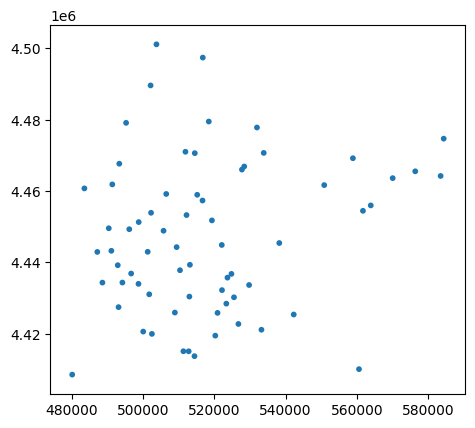

In [3]:
eagles.set_geometry('buffer', inplace=True)
eagles.plot()

Its hard to see if it worked or not, but it looks like the nests are smaller than the point marker so its probable that we sre seeing polygons. They just appear small at this scale.  Let's zoom in a bit.

<Axes: >

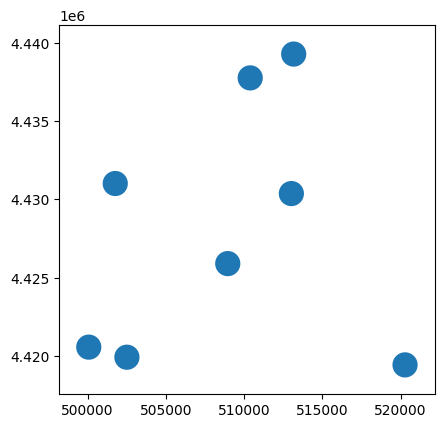

In [4]:
eagles.cx[500000:520000,4420000:4440000].plot()

Now lets take a look at the linears table.  We will have to convert it to UTM coordinates as well so we can use meters in our buffer distance.

In [5]:
linears.to_crs(epsg=26913, inplace=True)
linears.tail()

,postgis_fi,type,row_width,Project,geometry
1104,1105,Flowline,20.0,1105,"LINESTRING (520068.356 4437040.055, 520111.683..."
1105,1106,Pipeline,50.0,1106,"LINESTRING (509601.718 4442257.339, 509004.478..."
1106,1107,Pipeline,50.0,1107,"LINESTRING (516114.783 4442775.612, 516316.688..."
1107,1108,Pipeline,50.0,1108,"LINESTRING (512602.246 4440784.416, 512563.046..."
1108,1109,Pipeline,50.0,1109,"LINESTRING (530292.107 4432618.710, 530249.454..."


<Axes: >

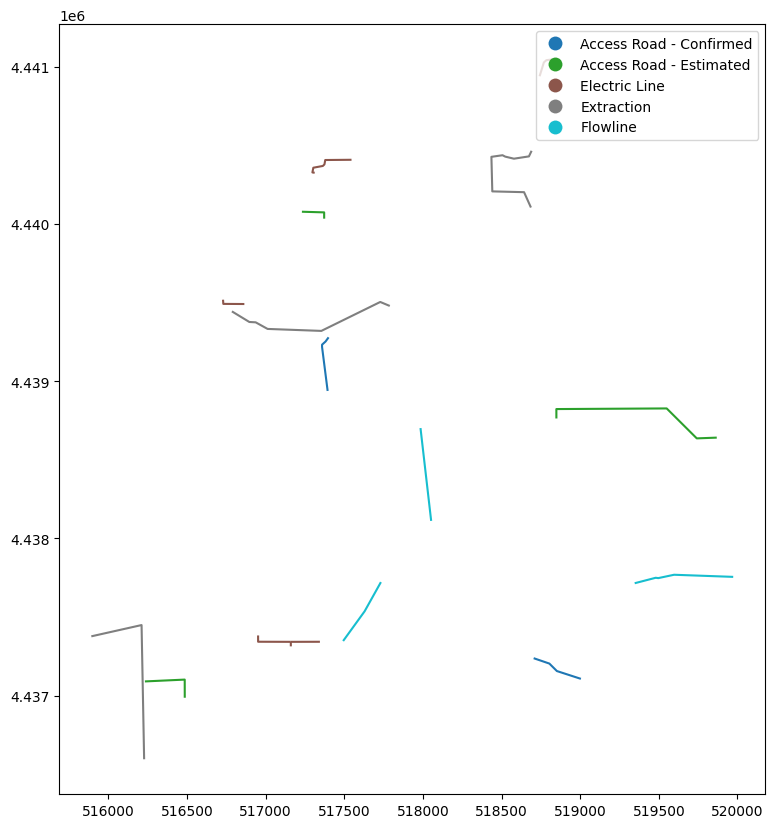

In [6]:
linears.cx[516000:520000, 4437000:4441000].plot(column='type', legend=True, figsize=(10,10))

We can see that in this area we have a number of linear projects.  These are pipelines, electric lines, access roads, etc associated with an oil and gas field in a region called the DJ Basin north of Denver, Colorado. The other layers represent wildlife species that are present and may impose environmental constraints on construction operations when they are present.  Each linear project has a right-of-way around it and it is assumed that the right away is the area of impact and so distance must be measured from it rather than from the line itself.  Thus we need to create right-of-way polygons by buffering the linear projects by the appropriate diatance.

This time we will pass the row_width column to the buffer function rather than a single distance so each polygon will be created as a buffer of the distance given in the row_width column.

In [7]:
linears['buffer'] = linears['geometry'].buffer(linears['row_width'])
linears.head()

,postgis_fi,type,row_width,Project,geometry,buffer
0,50,Flowline,20.0,50,"LINESTRING (534222.352 4449209.176, 534270.195...","POLYGON ((534282.759 4449186.104, 534284.224 4..."
1,67,Pipeline,50.0,67,"LINESTRING (495262.900 4435093.805, 494933.844...","POLYGON ((494910.422 4435224.098, 494906.185 4..."
2,68,Pipeline,50.0,68,"LINESTRING (496073.735 4439778.287, 496108.552...","POLYGON ((496158.060 4439538.863, 496158.552 4..."
3,69,Flowline,20.0,69,"LINESTRING (513615.900 4451888.839, 513673.823...","POLYGON ((513680.133 4451874.042, 513842.445 4..."
4,70,Flowline,20.0,70,"LINESTRING (519393.846 4451070.101, 519408.281...","POLYGON ((519395.343 4451097.598, 519396.886 4..."


C:\Anaconda\lib\site-packages\shapely\predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


<Axes: >

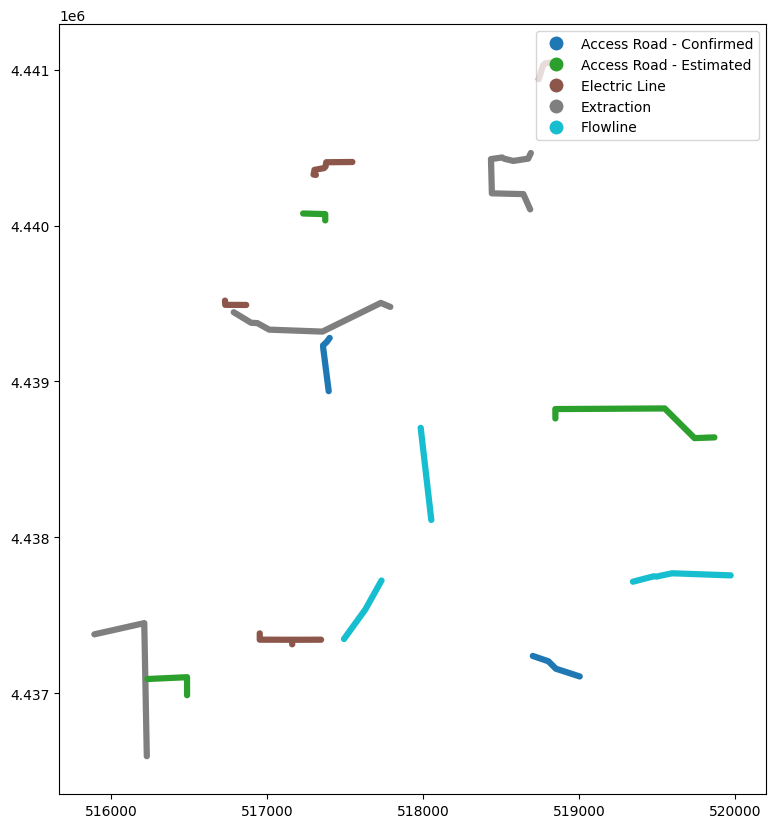

In [8]:
linears.set_geometry('buffer', inplace=True)
linears.cx[516000:520000, 4437000:4441000].plot(column='type', legend=True, figsize=(10,10))

It looks like we have polygon buffers but can we show that the distance are correct?

<Axes: >

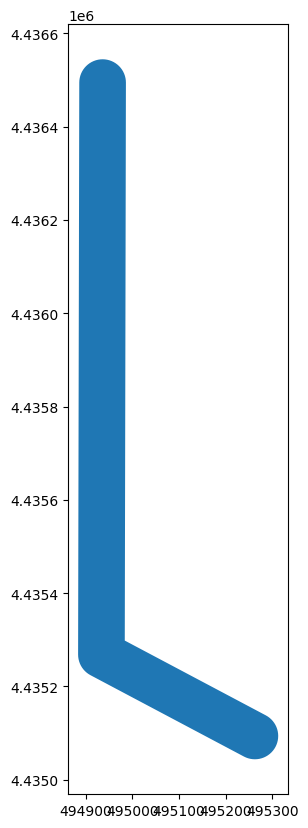

In [9]:
linears[linears['Project']==67].plot(figsize=(10,10))

In [10]:
linears[linears['Project']==67]

,postgis_fi,type,row_width,Project,geometry,buffer
1,67,Pipeline,50.0,67,"LINESTRING (495262.900 4435093.805, 494933.844...","POLYGON ((494910.422 4435224.098, 494906.185 4..."


That looks like the buffer is about 100m as it should be with a 50m row_width

<Axes: >

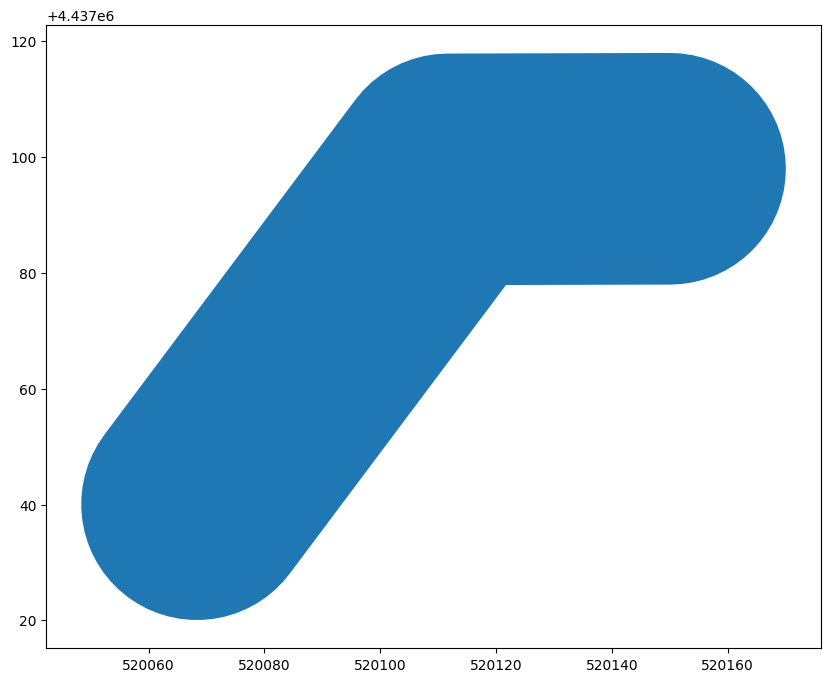

In [11]:
linears[linears['Project']==1105].plot(figsize=(10,10))

In [12]:
linears[linears['Project']==1105]

,postgis_fi,type,row_width,Project,geometry,buffer
1104,1105,Flowline,20.0,1105,"LINESTRING (520068.356 4437040.055, 520111.683...","POLYGON ((520095.677 4437109.878, 520096.992 4..."


And that looks like its 40m wide as it should be for a 20m row_width.

## Convex Hull

Convex hulls create a minimum convex polygon around a geometry.  We'll assign these to a GeoSeries named 'mcp'

<Axes: >

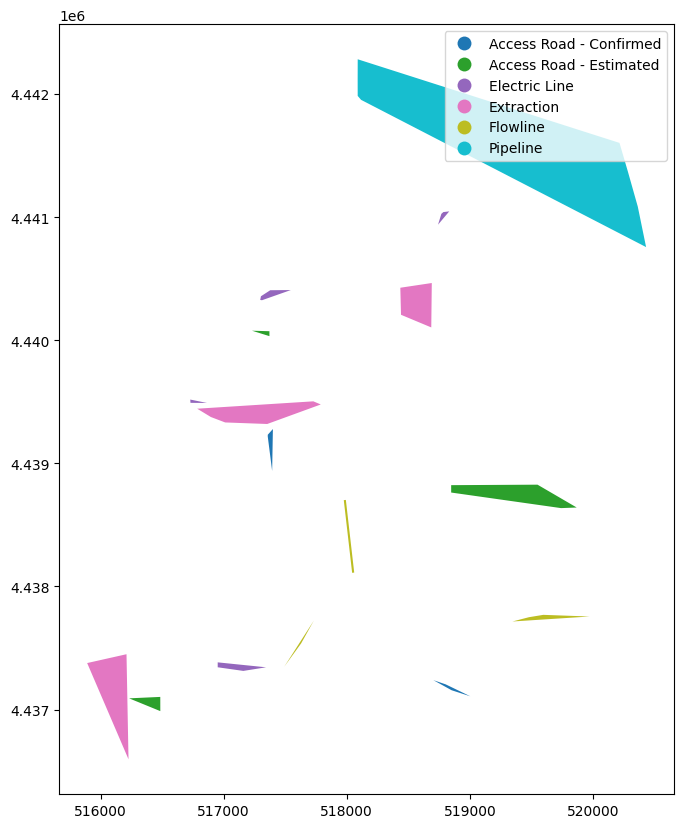

In [13]:
linears['mcp'] = linears['geometry'].convex_hull
linears.set_geometry('mcp', inplace=True)
linears.cx[516000:520000, 4437000:4441000].plot(column='type', legend=True, figsize=(10,10))

## Envelope

The envelope method creates a bounding box for each geometry. We'll store this in a field called bb.

<Axes: >

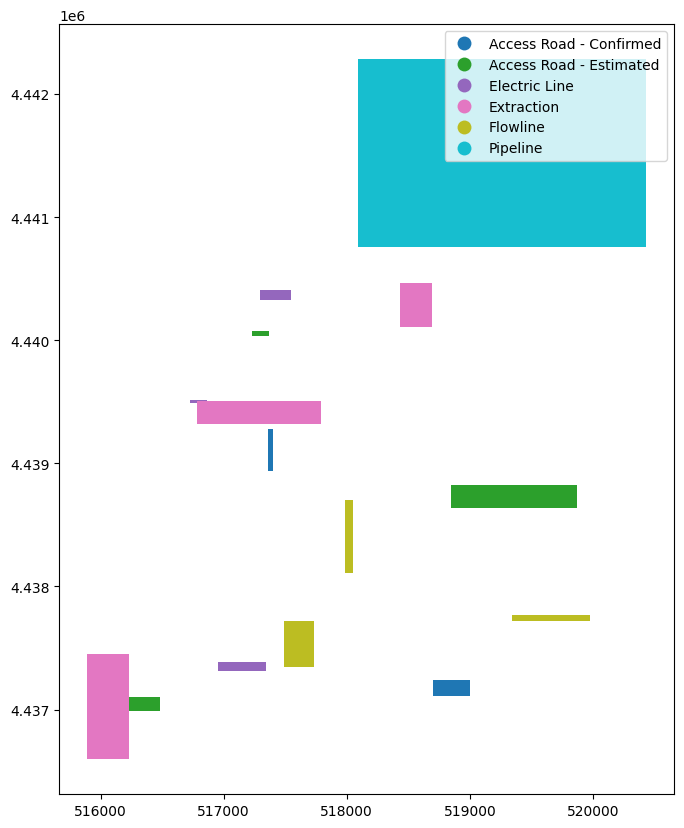

In [14]:
linears['bb'] = linears['geometry'].envelope
linears.set_geometry('bb', inplace=True)
linears.cx[516000:520000, 4437000:4441000].plot(column='type', legend=True, figsize=(10,10))

Now lets create buffers of 300m around the burrowing owl habitat.

In [15]:
buowl.to_crs(epsg=26913, inplace=True)

In [16]:
buowl['buffer']=buowl['geometry'].buffer(300)

<Axes: >

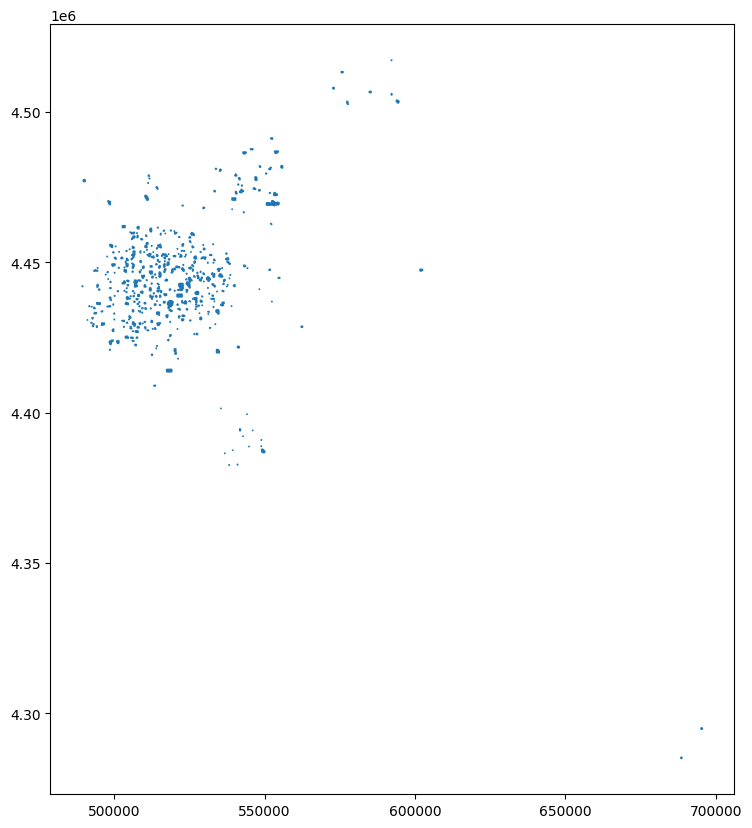

In [17]:
buowl.set_geometry('buffer').plot(figsize=(10,10))

## Centroid

We can also use the centroid method to create a point at the geometric center of the polygon.  **Note:** This centroid is not guaranteed to actually be inside the polygon.  If the polygon is simple it usually will be but for more complex polygons it might not be.

We will store the burrowing owl habitat's centroid in a column named centroid

In [18]:
buowl['centroid']=buowl['geometry'].centroid
buowl.head()

,postgis_fi,habitat,hist_occup,recentstat,habitat_id,active2017,geometry,buffer,centroid
0,15.0,Ground squirrel-mixed Vegetation,Undetermined,NO NESTING ACTIVITY OBSERVED,15,FALSE,"POLYGON ((532623.765 4446446.072, 532633.280 4...","POLYGON ((532374.983 4446613.725, 532392.784 4...",POINT (532534.321 4446167.269)
1,41.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,41,FALSE,"POLYGON ((529788.325 4443598.447, 529801.976 4...","POLYGON ((529522.846 4443738.165, 529537.780 4...",POINT (529793.042 4443587.534)
2,42.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,42,FALSE,"POLYGON ((534158.811 4440267.074, 534171.569 4...","POLYGON ((533860.014 4440240.227, 533858.817 4...",POINT (534171.685 4440258.213)
3,43.0,Ground squirrel-mixed Vegetation; removed 3/26/14,Undetermined,REMOVED,43,FALSE,"POLYGON ((526066.374 4447636.016, 526085.982 4...","POLYGON ((525788.576 4447522.752, 525778.898 4...",POINT (526079.802 4447623.425)
4,54.0,Active Prarie Dog Colony,Undetermined,NO NESTING ACTIVITY OBSERVED,54,FALSE,"POLYGON ((526901.134 4449915.454, 526893.541 4...","POLYGON ((526276.173 4449974.497, 526275.827 4...",POINT (526734.758 4450003.769)


<Axes: >

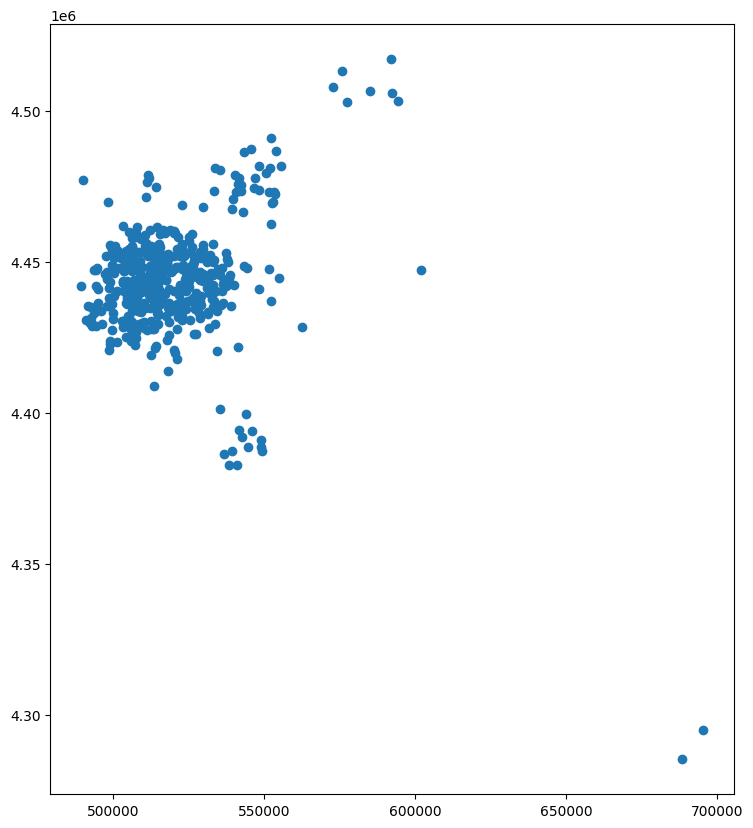

In [19]:
buowl.set_geometry('centroid').plot(figsize=(10,10))

There are more methods that create geometry but these are the most important ones.  You can see more information in the [GeoPandas](https://geopandas.org/geometric_manipulations.html) and [Shapely](https://shapely.readthedocs.io/en/latest/manual.html#constructive-methods) online documentation. 